In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from DiRect import *

/home/sangwoong/Projects/env/ml_research/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Trivial 1-D Example

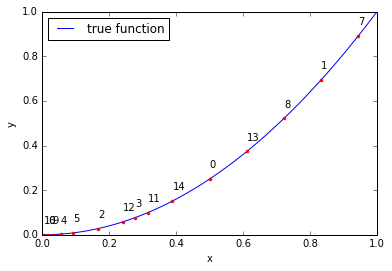

In [2]:
func_1d = lambda x: (x**2)[0] # f: vector to scalar
b = np.array([[0,1]])
direct = DiRect(func_1d, b, max_iter=4)
direct.run()
plt.figure()
x = np.linspace(b[0,0], b[0,1], 100).reshape((1,-1))
y = func_1d(x)
plt.plot(x.flatten(),y, label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
i = 0
for hist in direct.l_hist:
    plt.plot(hist[0], hist[1], 'r.')
    plt.text(hist[0], hist[1]+0.05, i)
    i += 1

# Non-Trivial 1D

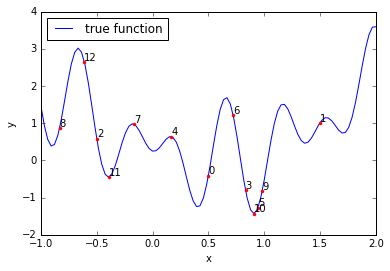

In [3]:
def func_1d(x):
    return ((x-0.5)**2 + np.sin(x*2.1)* np.sin(x*12)*1.7)
b = np.array([[-1,2]])
direct = DiRect(func_1d, b, max_feval=12)
direct.run()
plt.figure()
x = np.linspace(b[0,0], b[0,1], 100)
y = np.array([func_1d(xx) for xx in x])
true_opt = np.min(y)
plt.plot(x.flatten(),y, label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
i = 0
for hist in direct.l_hist:
    plt.plot(hist[0], hist[1], 'r.')
    plt.text(hist[0], hist[1]+0.05, i)
    i += 1
    

## Performance versus random search

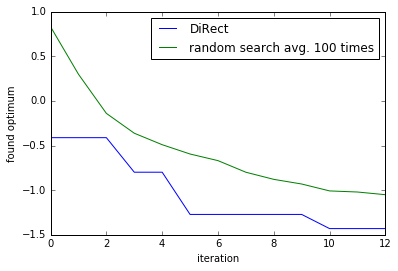

In [4]:
h = np.array([yy for xx, yy in direct.l_hist])
search = np.minimum.accumulate(h)

nRand = 100
rand_search = np.zeros((search.shape[0],))
for ii in xrange(nRand):
    np.random.shuffle(y)
    rand_search += np.minimum.accumulate(y[:search.shape[0]])
rand_search /= float(nRand)
plt.plot(search, label='DiRect')
plt.plot(rand_search, label='random search avg. 100 times')
plt.legend(loc='best')
plt.xlabel('iteration')
plt.ylabel('found optimum')

## Scikit-Learn Hyperparameter Search Demo

In [10]:
from sklearn import cross_validation
class DiRectHyperOpt(object):
    def __init__(self, model, train_x, train_y):
        self.model = model
        self.train_x = train_x
        self.train_y = train_y

    def vec2dict(self, vec):
        '''converts vector into sklearn-style hyparparameter specification
           {'<component>__<parameter>':hyperparam_value}'''
        return dict(zip(self.l_hyperparam_names, vec))
    
    def dict2vec(self,d):
        return np.vstack([d[name] for name in self.l_hyperparam_names])
            
    def f(self, vec):
        '''dHyperParams: dict, key: sklearn-style '<component>__<parameter>' string,
                            value: '''
        vec = 10 ** vec
        dHyperparam = self.vec2dict(vec)
        self.model.set_params(**dHyperparam)
        l_cv_scores = cross_validation.cross_val_score(self.model, self.train_x, self.train_y, cv=self.nCV)
        cv_score = np.mean(l_cv_scores)
        return cv_score

    def run_opt(self, bounds, max_feval=40):
        '''bounds : dict. key: sklearn-style '<component>__<parameter>' string,
                    value: np 1D array ([lower, upper])'''
        # bound of each hyperparameter should be specified in 1D np array
        for value in bounds.values():
            assert len(value.shape) == 1
            assert value.shape[0] == 2
        self.l_hyperparam_names = bounds.keys()
        bound_matrix = self.dict2vec(bounds)
        self.nCV = 5
            
        direct = DiRect(self.f, bound_matrix, max_feval=max_feval, minimize=False)
        opt_val, x_at_opt, l_hist = direct.run()
        
        self.f(x_at_opt)
        print 'done'
#         print l_hist
        print opt_val, self.vec2dict(x_at_opt)
        return self.model

In [ ]:
? model.score

In [7]:
from sklearn.datasets import load_boston
boston = load_boston()
train_x = boston.data
train_y = boston.target

In [11]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.grid_search import GridSearchCV
model = KernelRidge(kernel='rbf')
direct = DiRectHyperOpt(model, train_x, train_y)
# direct.run_opt(np.array([[-6, 0],[-6, 0]]))
direct.run_opt({'alpha':np.array([-7, 0]), 'gamma':np.array([-6,0])})

done
0.467806593434 {'alpha': -2.7222222222222214, 'gamma': -5.6666666666666661}


KernelRidge(alpha=0.0018957356524063793, coef0=1, degree=3,
      gamma=2.1544346900318865e-06, kernel='rbf', kernel_params=None)